In [1]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
tf.config.list_physical_devices('GPU')

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
import os
train_dir = f"{os.getcwd()}\\..\\data\\tr"
batch_size = 32
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [6]:
BUFFER_SIZE = 50000

In [7]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [8]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [9]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'kun joku antaa lahjan syd\xc3\xa4mest\xc3\xa4\xc3\xa4n, - kuten te annoitte minulle tupakan, muistan sen syd\xc3\xa4mess\xc3\xa4ni.'
Label: 2


In [10]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'jutut luistaa ihan hyvin, mutta muistan kyll\xc3\xa4 pari syv\xc3\xa4\xc3\xa4 haukotusta. :d'
 b'kun sitten huomattiin , ett\xc3\xa4 osa ihmisist\xc3\xa4 kuitenkin kiinnostui islamista ja k\xc3\xa4\xc3\xa4ntyi "muslimeiksi" pelottelusta huolimatta..'
 b'niittylahti suhmura juntit kyl\xc3\xa4npojat m\xc3\xb6kin miinat haisevat.']

labels:  [2 1 0]
51662 ['' '[UNK]' 'on' 'ja' 'ei' 'se' 'että' 'ole' 'en' 'mutta' 'kun' 'jos'
 'niin' 'hän' 'olen' 'mitä' 'oli' 'voi' 'nyt' 'kuin']
[[ 1241  7856    46    47     9  1587    29   288  6898 46107   231     0
      0     0     0]
 [   10    28 45035     6   274  1614   108 40832 14833     3  7974 34061
  30662  1324     0]
 [33270 24816 42948 38585  7634 12906  6084     0     0     0     0     0
      0     0     0]]
Original:  b'jutut luistaa ihan hyvin, mutta muistan kyll\xc3\xa4 pari syv\xc3\xa4\xc3\xa4 haukotusta. :d'
Round-trip:  jutut luistaa ihan hyvin mutta muistan kyllä pari syvää haukotusta d    

Original:  b'kun sitten huomat

In [12]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [13]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=False),
        layers.Bidirectional(layers.LSTM(128, dropout=0.1, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
        layers.Dropout(0.10),
        layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.10),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [14]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=optimizers.Adamax(0.005),
    loss=losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=10)
model.summary()

Epoch 1/10
961/961 [==============================] - 50s 23ms/step - loss: 0.9218 - accuracy: 0.5744 - val_loss: 0.8699 - val_accuracy: 0.6204
Epoch 2/10
961/961 [==============================] - 18s 19ms/step - loss: 0.7495 - accuracy: 0.7056 - val_loss: 0.7934 - val_accuracy: 0.6834
Epoch 3/10
961/961 [==============================] - 19s 20ms/step - loss: 0.5845 - accuracy: 0.8047 - val_loss: 0.7956 - val_accuracy: 0.7062
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 32)          1653184   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        164864    
 l)                 

In [15]:
model.save(f'E:\Emodim\data\others\\rnn_{time}')
# model.save(f'model/rnn_{time}.h5')

INFO:tensorflow:Assets written to: E:\Emodim\data\others\rnn_10-06-2022_10-09-51\assets


INFO:tensorflow:Assets written to: E:\Emodim\data\others\rnn_10-06-2022_10-09-51\assets


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

107/107 [==============================] - 1s 8ms/step - loss: 0.7956 - accuracy: 0.7062
Test Loss: 0.7956179976463318
Test Accuracy: 0.7062097191810608


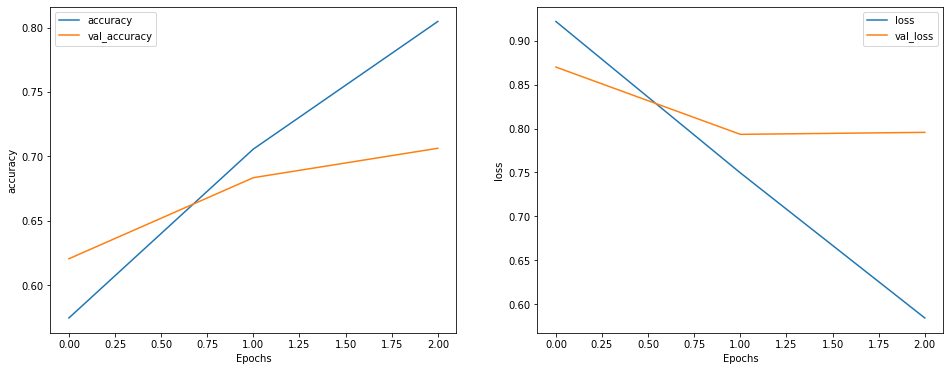

In [17]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [18]:
modelpath = f"E:\Emodim\data\others\\rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 32)          1653184   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [19]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['Autot katsastukseen puolen vuoden välein .... ' 'Kuinka vaan. '
 'Mutta oikeastaan en ihmettelle tätä lainkaan sillä tämähän on kuiva ja karu Suomi jossa mies ei puhu eikä pussa ja jos tekee molempia ja on hyvä jobi niin on seksuaalinenahdistelija!!!!! '
 'taidanpa sen joskus tässä hankkiakin ja lueskella läpi.. '
 'Poliisillakin on resurssipula, joten ne ei jouda tutkaamaan joka nurkalla. ']


In [20]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

1/1 [==============================] - 3s 3s/step
Sentence: Autot katsastukseen puolen vuoden välein .... 
Predicted label: 0
Predicted probs: 0.91631, 0.03278, 0.05091

Sentence: Kuinka vaan. 
Predicted label: 1
Predicted probs: 0.29285, 0.65022, 0.05693

Sentence: Mutta oikeastaan en ihmettelle tätä lainkaan sillä tämähän on kuiva ja karu Suomi jossa mies ei puhu eikä pussa ja jos tekee molempia ja on hyvä jobi niin on seksuaalinenahdistelija!!!!! 
Predicted label: 1
Predicted probs: 0.00076, 0.97582, 0.02343

Sentence: taidanpa sen joskus tässä hankkiakin ja lueskella läpi.. 
Predicted label: 1
Predicted probs: 0.06226, 0.72905, 0.20869

Sentence: Poliisillakin on resurssipula, joten ne ei jouda tutkaamaan joka nurkalla. 
Predicted label: 1
Predicted probs: 0.00808, 0.96011, 0.03182

['Autot katsastukseen puolen vuoden välein .... ' 'Kuinka vaan. '
 'Mutta oikeastaan en ihmettelle tätä lainkaan sillä tämähän on kuiva ja karu Suomi jossa mies ei puhu eikä pussa ja jos tekee molempia 